In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

#sys.path.insert(0,'../') #add pyRayleighCuda to path

#display options for the notebook
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['image.cmap'] = 'magma'
mpl.rcParams['image.interpolation'] = 'none'

%matplotlib inline

In [2]:
#Setup pyRayleighCuda paths
#Add path to transducers.py and GPU build
sys.path.insert(0,'../')
sys.path.append('../../../HiFU/code/CUDA/RSgpu/Release')
import transducers
import geom

## Create a spherical randomized array

In [3]:
r_foc=72.0      #Radius of curvature (mm)
diam = 103.0    #Diameter of opening face (mm)

ellDiam = 3.3   #Diameter of transmit elements

N=192           #Number of elements

uxyz = geom.new_randomized_spherecap_array(r_foc, diam, N, elementDiam=ellDiam, iterations=2000)

focus = [0,0,r_foc]

unormals = focus - uxyz

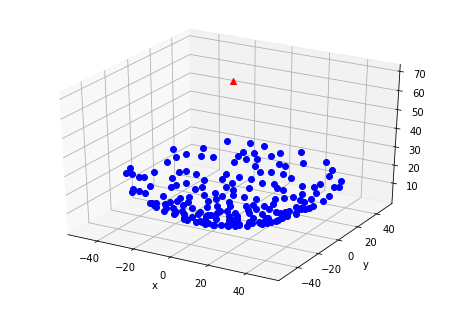

In [5]:
fig = plt.figure()

ax = Axes3D(fig)
plt.plot(uxyz[:,0], uxyz[:,1], uxyz[:,2], 'bo' )
plt.plot([focus[0]], [focus[1]], [focus[2]], 'r^' )

plt.xlabel('x')
plt.ylabel('y')


(-56.098011627482812,
 56.505103032308703,
 -56.317563895136082,
 55.381125745154684)

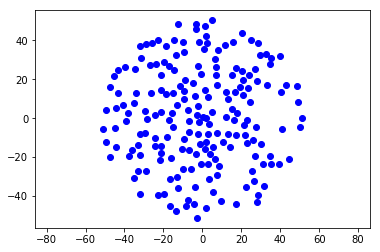

In [5]:
plt.plot(uxyz[:,0], uxyz[:,1],'bo')
plt.axis('equal')

## Computate pressure on a lateral plane (at the focus) and an axial plane

In [6]:
dx,dy,dz = (.25,.25,.25) #resolution (mm)
x_lat = np.arange(-diam/8.0, diam/8.0 +dx, dx )
y_lat = x_lat
z_lat = [r_foc]

x_axi = np.arange(-diam/8.0, diam/8.0 +dx, dx )
y_axi = [0.0]
z_axi = np.arange(r_foc/2.0, 1.5*r_foc +dz, dz )

#### Narrow-band transmit 

In [7]:
fc = 1.2e6 #Frequency in Hz
c0 = 1480  #sound speed

kr_mm = 2*np.pi*fc/c0*1e-3 #wavenumber in radians/mm

In [8]:
uamp = np.ones(N,dtype=np.complex)

pXZ = transducers.calc_pressure_field(kr_mm, uxyz, uamp, x_axi, y_axi, z_axi, unormals=unormals)
pXY = transducers.calc_pressure_field(kr_mm, uxyz, uamp, x_lat, y_lat, z_lat, unormals=unormals)

#remove the singleton dimension since these are 2-D planes
pXZ = pXZ.squeeze()
pXY = pXY.squeeze()

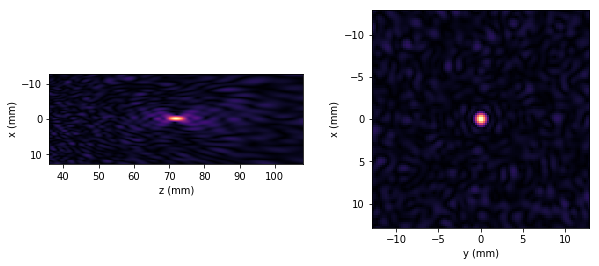

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(pXZ), extent=[z_axi[0], z_axi[-1], x_axi[-1], x_axi[0]])
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')

plt.subplot(122)
plt.imshow(np.abs(pXY), extent=[y_lat[0], y_lat[-1], x_lat[-1], x_lat[0]])
plt.xlabel('y (mm)')
plt.ylabel('x (mm)')

### Multi-focal

In [46]:
foci = [[-5.0, 0.0, r_foc], [5.0, 0.0, r_foc], [0.0, 5.0, r_foc], [0.0, -5.0, r_foc]]
foci_weights = np.ones(len(foci))
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci, foci_weights)

pXZ = transducers.calc_pressure_field(kr_mm, uxyz, uamp, x_axi, y_axi, z_axi, unormals=unormals)
pXY = transducers.calc_pressure_field(kr_mm, uxyz, uamp, x_lat, y_lat, z_lat, unormals=unormals)

#remove the singleton dimension since these are 2-D planes
pXZ = pXZ.squeeze()
pXY = pXY.squeeze()

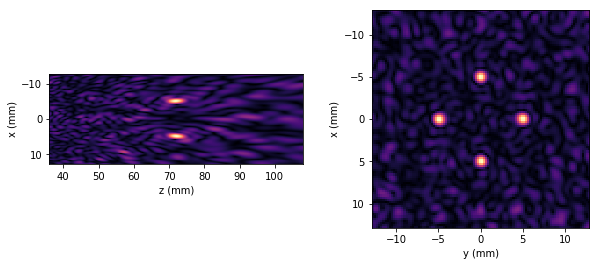

In [47]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(pXZ), extent=[z_axi[0], z_axi[-1], x_axi[-1], x_axi[0]])
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')

plt.subplot(122)
plt.imshow(np.abs(pXY), extent=[y_lat[0], y_lat[-1], x_lat[-1], x_lat[0]])
plt.xlabel('y (mm)')
plt.ylabel('x (mm)')

# CUDA version
Everything is the same except for the interface routines `calc_pressure_*`

In [48]:
pXZ = transducers.calc_pressure_field_cuda(kr_mm, uxyz, uamp, x_axi, y_axi, z_axi, unormals=unormals)
pXY = transducers.calc_pressure_field_cuda(kr_mm, uxyz, uamp, x_lat, y_lat, z_lat, unormals=unormals)

#remove the singleton dimension since these are 2-D planes
pXZ = pXZ.squeeze()
pXY = pXY.squeeze()

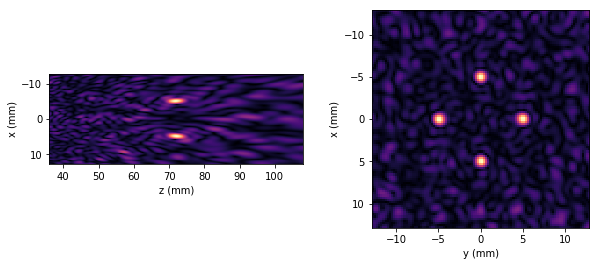

In [56]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(pXZ), extent=[z_axi[0], z_axi[-1], x_axi[-1], x_axi[0]])
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')

plt.subplot(122)
plt.imshow(np.abs(pXY), extent=[y_lat[0], y_lat[-1], x_lat[-1], x_lat[0]])
plt.xlabel('y (mm)')
plt.ylabel('x (mm)')

### Compare volume computation time

The 3D volume must be small enough to fit in GPU memory... `cudaDeviceSynchronize()` errors may indicate not enough memory

In [73]:
dx,dy,dz = (.35, .35, .35) #resolution (mm)
xp3d = np.arange(-diam/8.0, diam/8.0 +dx, dx )
yp3d = xp3d
zp3d = np.arange(65.0, 80.0 +dz, dz )
#zp3d = [60.0, 72.0]

print('Size of volume is :', [len(xp3d), len(yp3d),len(zp3d)] )

Size of volume is : [75, 75, 44]


#### CPU

In [37]:
%%timeit
transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp3d, yp3d, zp3d, unormals=unormals)


1 loop, best of 3: 8.87 s per loop


#### GPU

In [24]:
%%timeit
transducers.calc_pressure_field_cuda(kr_mm, uxyz, uamp, xp3d, yp3d, zp3d, unormals=unormals)


1 loop, best of 3: 995 ms per loop


In [74]:
p_gpu = transducers.calc_pressure_field_cuda(kr_mm, uxyz, uamp, xp3d, yp3d, zp3d, unormals=unormals)

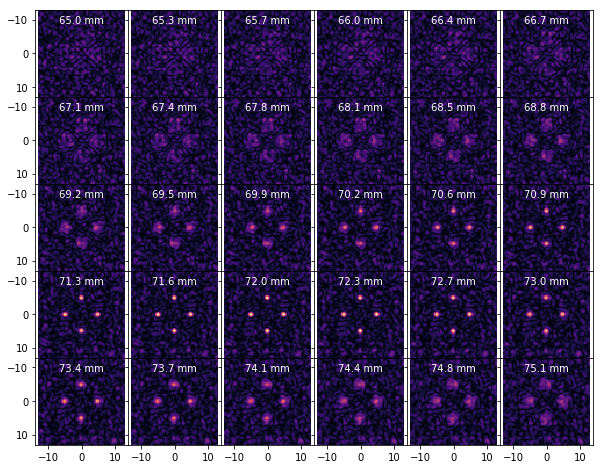

In [102]:

fig,axs = plt.subplots(5,6, squeeze=True, sharex=True,sharey=True, gridspec_kw=dict(wspace=0, hspace=0), figsize=(10,8))

p_max = np.abs(p_gpu).max()

for i in range(30):
    plt.sca(axs.flat[i])
    plt.imshow( np.abs( p_gpu[:,:,i] ), vmin=0,vmax=p_max, extent=[yp3d[0], yp3d[-1], xp3d[-1], xp3d[0]])
    plt.text(0.5,0.85,'%0.1f mm'%zp3d[i], color='w', transform=plt.gca().transAxes, ha='center' )
    